# Sentiment Classification of Movie Reviews (using Naive Bayes, Logistic Regression, and Ngrams)

The purpose of this notebook is to cover Naive Bayes, Logistic regression, and ngrams (some pretty classic techniques!) for sentiment classification.  We will be using sklearn and the fastai library.

In a future lesson, we will tackle this same problem of sentiment classification using deep learning, so that you can compare the two approaches

The content here was extended from [Lesson 10 of the fast.ai Machine Learning course](https://course.fast.ai/lessonsml1/lesson10.html). Linear model is pretty close to the state of the art here.  Jeremy surpassed state of the art using a RNN in fall 2017.

## The fastai library

We will begin using [the fastai library](https://docs.fast.ai) (version 1.0) in this notebook.  We will use it more once we move on to neural networks.

The fastai library is built on top of PyTorch and encodes many state-of-the-art best practices. It is used in production at a number of companies.  You can read more about it here:

- [Fast.ai's software could radically democratize AI](https://www.zdnet.com/article/fast-ais-new-software-could-radically-democratize-ai/) (ZDNet)

- [fastai v1 for PyTorch: Fast and accurate neural nets using modern best practices](https://www.fast.ai/2018/10/02/fastai-ai/) (fast.ai)

- [fastai docs](https://docs.fast.ai/)

### Installation

With conda:

`conda install -c pytorch -c fastai fastai=1.0`

Or with pip:

`pip install fastai==1.0`

More [installation information here](https://github.com/fastai/fastai/blob/master/README.md).

Beginning in lesson 4, we will be using GPUs, so if you want, you could switch to a [cloud option](https://course.fast.ai/#using-a-gpu) now to setup fastai.

## IMDB dataset

The [large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) contains a collection of 50,000 reviews from IMDB, We will use the version hosted as part [fast.ai datasets](https://course.fast.ai/datasets.html) on AWS Open Datasets. 

The dataset contains an even number of positive and negative reviews. The authors considered only highly polarized reviews. A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. Neutral reviews are not included in the dataset. The dataset is divided into training and test sets. The training set is the same 25,000 labeled reviews.

The **sentiment classification task** consists of predicting the polarity (positive or negative) of a given text.

### Imports

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.text import *

In [4]:
import sklearn.feature_extraction.text as sklearn_text

### Tokenizing and term document matrix creation

fast.ai has a number of [datasets hosted via AWS Open Datasets](https://course.fast.ai/datasets.html) for easy download. We can see them by checking the docs for URLs (remember `??` is a helpful command):

In [273]:
?? URLs

It is always good to start working on a sample of your data before you use the full dataset-- this allows for quicker computations as you debug and get your code working. For IMDB, there is a sample dataset already available:

In [5]:
path = untar_data(URLs.IMDB_SAMPLE)
path

PosixPath('/home/racheltho/.fastai/data/imdb_sample')

We are not going to use this dataframe, but are just loading it to get a sense of what our data looks like:

In [6]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


We will be using [TextList](https://docs.fast.ai/text.data.html#TextList) from the fastai library:

In [7]:
movie_reviews = (TextList.from_csv(path, 'texts.csv', cols='text')
                         .split_from_df(col=2)
                         .label_from_df(cols=0))

### Exploring what our data looks like

A good first step for any data problem is to explore the data and get a sense of what it looks like.  In this case we are looking at movie reviews, which have been labeled as "positive" or "negative":

In [8]:
movie_reviews.valid.x[0], movie_reviews.valid.y[0]

(Text xxbos xxmaj this very funny xxmaj british comedy shows what might happen if a section of xxmaj london , in this case xxmaj xxunk , were to xxunk itself independent from the rest of the xxup uk and its laws , xxunk & post - war xxunk . xxmaj merry xxunk is what would happen . 
  
   xxmaj the explosion of a wartime bomb leads to the xxunk of ancient xxunk which show that xxmaj xxunk was xxunk to the xxmaj xxunk of xxmaj xxunk xxunk ago , a small historical xxunk long since forgotten . xxmaj to the new xxmaj xxunk , however , this is an unexpected opportunity to live as they please , free from any xxunk from xxmaj xxunk . 
  
   xxmaj stanley xxmaj xxunk is excellent as the minor city xxunk who suddenly finds himself leading one of the world 's xxunk xxunk . xxmaj xxunk xxmaj margaret xxmaj xxunk is a delight as the history professor who sides with xxmaj xxunk . xxmaj others in the stand - out cast include xxmaj xxunk xxmaj xxunk , xxmaj paul xxmaj xxunk , xxmaj xxunk xxmaj xxunk ,

In NLP, a **token** is the basic unit of processing (what the tokens are depends on the application and your choices). Here, the tokens mostly correspond to words or punctuation, as well as several special tokens, corresponding to unknown words, capitalization, etc.

All those tokens starting with "xx" are fastai special tokens.  You can see the list of all of them and their meanings ([in the fastai docs](https://docs.fast.ai/text.transform.html)): 

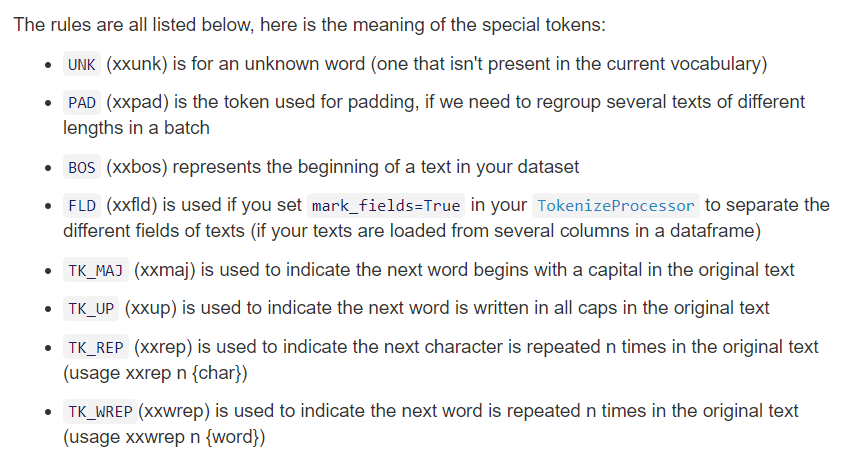

In [9]:
len(movie_reviews.train.x), len(movie_reviews.valid.x)

(800, 200)

Notice that ints-to-string and string-to-ints have different lengths.  Think for a moment about why this is:

In [10]:
len(movie_reviews.vocab.itos), len(movie_reviews.vocab.stoi)

(6016, 19160)

In [11]:
movie_reviews.vocab.stoi['language']

917

In [12]:
movie_reviews.vocab.itos[917]

'language'

In [13]:
movie_reviews.vocab.itos[20:30]

['that', 'this', '"', "'s", '\n \n ', '-', 'was', 'as', 'for', 'movie']

In [14]:
movie_reviews.vocab.itos[6009]

'sollett'

In [15]:
movie_reviews.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 '.',
 ',',
 'and',
 'a',
 'of',
 'to',
 'is',
 'it',
 'in',
 'i']

In [16]:
movie_reviews.vocab.stoi

defaultdict(int,
            {'xxunk': 0,
             'xxpad': 1,
             'xxbos': 2,
             'xxeos': 3,
             'xxfld': 4,
             'xxmaj': 5,
             'xxup': 6,
             'xxrep': 7,
             'xxwrep': 8,
             'the': 9,
             '.': 10,
             ',': 11,
             'and': 12,
             'a': 13,
             'of': 14,
             'to': 15,
             'is': 16,
             'it': 17,
             'in': 18,
             'i': 19,
             'that': 20,
             'this': 21,
             '"': 22,
             "'s": 23,
             '\n \n ': 24,
             '-': 25,
             'was': 26,
             'as': 27,
             'for': 28,
             'movie': 29,
             'with': 30,
             'but': 31,
             'film': 32,
             'you': 33,
             ')': 34,
             'on': 35,
             '(': 36,
             "n't": 37,
             'are': 38,
             'he': 39,
             'his': 40,
       

Let's test that a non-word maps to xxunk:

In [17]:
movie_reviews.vocab.itos[movie_reviews.vocab.stoi['rrachell']]

'xxunk'

In [18]:
movie_reviews.vocab.itos[movie_reviews.vocab.stoi['language']]

'language'

In [22]:
t = movie_reviews.train[0][0]

In [26]:
t.data[:30]

array([   2,    5, 4622,   25,    0,   25,  867,   52,    5, 3776,    5, 1800,   95,   37,   85,  191,   63,  936,
          0, 2740,  517,   18,   21,   11,   84, 2418,  192,   88, 3777,   63])

## Creating our term-document matrix

As we covered in the last lesson, a term-document matrix represents a document as a "bag of words", that is, we don't keep track of the order the words are in, just which words occur (and how often).

In the previous lesson, we used [sklearn's CountVectorizer](https://github.com/scikit-learn/scikit-learn/blob/55bf5d9/sklearn/feature_extraction/text.py#L940).  Today we will create our own (similar) version.  This is for two reasons:
- to understand what sklearn is doing underneath the hood
- to create something that will work with a fastai TextList

To create our term-document matrix, we first need to learn about **counters** and **sparse matrices**.

### Counters

Counters are a useful Python object.  If you aren't familar with them, here is how they work:

In [181]:
c = Counter([4,2,8,8,4,8])

In [248]:
c

Counter({4: 2, 2: 1, 8: 3})

In [182]:
c.values()

dict_values([2, 1, 3])

In [183]:
c.keys()

dict_keys([4, 2, 8])

Counters are from the collections module (along with OrderedDict, defaultdict, deque, and namedtuple).

### Sparse Matrices (in Scipy)

Even though we've reduced over 19,000 words down to 6,000, that is still a lot! Most tokens don't appear in most reviews.  We want to take advantage of this by storing our data as a **sparse matrix**.

A matrix with lots of zeros is called **sparse** (the opposite of sparse is **dense**).  For sparse matrices, you can save a lot of memory by only storing the non-zero values.

<img src="images/sparse.png" alt="floating point" style="width: 30%"/>

Another example of a large, sparse matrix:

<img src="images/Finite_element_sparse_matrix.png" alt="floating point" style="width: 30%"/>

[Source](https://commons.wikimedia.org/w/index.php?curid=2245335)

There are the most common sparse storage formats:
- coordinate-wise (scipy calls COO)
- compressed sparse row (CSR)
- compressed sparse column (CSC)

Let's walk through [these examples](http://www.mathcs.emory.edu/~cheung/Courses/561/Syllabus/3-C/sparse.html)

There are actually [many more formats](http://www.cs.colostate.edu/~mcrob/toolbox/c++/sparseMatrix/sparse_matrix_compression.html) as well.

A class of matrices (e.g, diagonal) is generally called sparse if the number of non-zero elements is proportional to the number of rows (or columns) instead of being proportional to the product rows x columns.

**Scipy Implementation**

From the [Scipy Sparse Matrix Documentation](https://docs.scipy.org/doc/scipy-0.18.1/reference/sparse.html)

- To construct a matrix efficiently, use either dok_matrix or lil_matrix. The lil_matrix class supports basic slicing and fancy indexing with a similar syntax to NumPy arrays. As illustrated below, the COO format may also be used to efficiently construct matrices
- To perform manipulations such as multiplication or inversion, first convert the matrix to either CSC or CSR format.
- All conversions among the CSR, CSC, and COO formats are efficient, linear-time operations.

### Our version of CountVectorizer

In [263]:
Counter((movie_reviews.valid.x)[0].data)

Counter({2: 1,
         5: 32,
         21: 3,
         71: 1,
         189: 1,
         748: 1,
         289: 1,
         285: 1,
         62: 2,
         221: 1,
         666: 2,
         59: 1,
         13: 4,
         2707: 1,
         14: 6,
         2877: 1,
         11: 10,
         18: 2,
         358: 1,
         0: 32,
         77: 1,
         15: 6,
         478: 1,
         1833: 1,
         50: 3,
         9: 10,
         319: 1,
         6: 1,
         2745: 1,
         12: 1,
         115: 1,
         4129: 1,
         197: 2,
         1331: 1,
         25: 2,
         324: 1,
         10: 7,
         3963: 1,
         16: 4,
         74: 1,
         24: 3,
         2819: 1,
         5823: 1,
         2597: 1,
         710: 1,
         3430: 1,
         84: 1,
         149: 1,
         20: 1,
         26: 1,
         605: 1,
         378: 1,
         1057: 1,
         251: 1,
         258: 1,
         1346: 1,
         194: 1,
         239: 1,
         49: 1,
         27

In [264]:
movie_reviews.vocab.itos[6]

'xxup'

In [1]:
(movie_reviews.valid.x)[1]

NameError: name 'movie_reviews' is not defined

In [258]:
(movie_reviews.valid.x)[0]

Text xxbos xxmaj this very funny xxmaj british comedy shows what might happen if a section of xxmaj london , in this case xxmaj xxunk , were to xxunk itself independent from the rest of the xxup uk and its laws , xxunk & post - war xxunk . xxmaj merry xxunk is what would happen . 
 
  xxmaj the explosion of a wartime bomb leads to the xxunk of ancient xxunk which show that xxmaj xxunk was xxunk to the xxmaj xxunk of xxmaj xxunk xxunk ago , a small historical xxunk long since forgotten . xxmaj to the new xxmaj xxunk , however , this is an unexpected opportunity to live as they please , free from any xxunk from xxmaj xxunk . 
 
  xxmaj stanley xxmaj xxunk is excellent as the minor city xxunk who suddenly finds himself leading one of the world 's xxunk xxunk . xxmaj xxunk xxmaj margaret xxmaj xxunk is a delight as the history professor who sides with xxmaj xxunk . xxmaj others in the stand - out cast include xxmaj xxunk xxmaj xxunk , xxmaj paul xxmaj xxunk , xxmaj xxunk xxmaj xxunk , xxma

In [184]:
def get_term_doc_matrix(label_list, vocab_len):
    j_indices = []
    indptr = []
    values = []
    indptr.append(0)

    for i, doc in enumerate(label_list):
        feature_counter = Counter(doc.data)
        j_indices.extend(feature_counter.keys())
        values.extend(feature_counter.values())
        indptr.append(len(j_indices))
        
#     return (values, j_indices, indptr)

    return scipy.sparse.csr_matrix((values, j_indices, indptr),
                                   shape=(len(indptr) - 1, vocab_len),
                                   dtype=int)

In [185]:
%%time
val_term_doc = get_term_doc_matrix(movie_reviews.valid.x, len(movie_reviews.vocab.itos))

CPU times: user 56 ms, sys: 0 ns, total: 56 ms
Wall time: 54.9 ms


In [186]:
%%time
trn_term_doc = get_term_doc_matrix(movie_reviews.train.x, len(movie_reviews.vocab.itos))

CPU times: user 212 ms, sys: 4 ms, total: 216 ms
Wall time: 210 ms


In [187]:
trn_term_doc.shape

(800, 6010)

In [269]:
trn_term_doc[:,-10:]

<800x10 sparse matrix of type '<class 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [188]:
val_term_doc.shape

(200, 6010)

### More data exploration

We could convert our sparse matrix to a dense matrix:

In [272]:
movie_reviews.vocab.itos[-1:]

['sollett']

In [189]:
val_term_doc.todense()[:10,:10]

matrix([[32,  0,  1,  0, ...,  1,  0,  0, 10],
        [ 9,  0,  1,  0, ...,  1,  0,  0,  7],
        [ 6,  0,  1,  0, ...,  0,  0,  0, 12],
        [78,  0,  1,  0, ...,  0,  0,  0, 44],
        ...,
        [ 8,  0,  1,  0, ...,  0,  0,  0,  8],
        [43,  0,  1,  0, ...,  8,  1,  0, 25],
        [ 7,  0,  1,  0, ...,  1,  0,  0,  9],
        [19,  0,  1,  0, ...,  2,  0,  0,  5]])

In [190]:
movie_reviews.vocab.itos[3]

'xxeos'

In [191]:
review = movie_reviews.valid.x[1]; review

Text xxbos i saw this movie once as a kid on the late - late show and fell in love with it . 
 
  xxmaj it took 30 + years , but i recently did find it on xxup dvd - it was n't cheap , either - in a xxunk that xxunk in war movies . xxmaj we watched it last night for the first time . xxmaj the audio was good , however it was grainy and had the trailers between xxunk . xxmaj even so , it was better than i remembered it . i was also impressed at how true it was to the play . 
 
  xxmaj the xxunk is around here xxunk . xxmaj if you 're xxunk in finding it , fire me a xxunk and i 'll see if i can get you the xxunk . xxunk

**Exercise:** Since the word "late" shows up twice in this review ("...as a kid on the late - late show..."), confirm that a value of 2 is stored in the term-document matrix, for the row corresponding to this review and the column corresponding to the word "late".

#### Answer:

In [194]:
# Exercise: Confirm this


451


2

In [195]:
val_term_doc

<200x6010 sparse matrix of type '<class 'numpy.int64'>'
	with 27848 stored elements in Compressed Sparse Row format>

In [196]:
val_term_doc[1]

<1x6010 sparse matrix of type '<class 'numpy.int64'>'
	with 81 stored elements in Compressed Sparse Row format>

In [197]:
val_term_doc[1].sum()

144

The review has 81 distinct tokens in it, and 144 tokens total.

In [198]:
review.data

array([  2,  19, 248,  21, ...,   9,   0,  10,   0])

**Exercise:** How could you convert review.data back to text (without just using review.text)?

#### Answer

In [199]:
# Exercise

[movie_reviews.vocab.itos[a] for a in review.data]

['xxbos',
 'i',
 'saw',
 'this',
 'movie',
 'once',
 'as',
 'a',
 'kid',
 'on',
 'the',
 'late',
 '-',
 'late',
 'show',
 'and',
 'fell',
 'in',
 'love',
 'with',
 'it',
 '.',
 '\n \n ',
 'xxmaj',
 'it',
 'took',
 '30',
 '+',
 'years',
 ',',
 'but',
 'i',
 'recently',
 'did',
 'find',
 'it',
 'on',
 'xxup',
 'dvd',
 '-',
 'it',
 'was',
 "n't",
 'cheap',
 ',',
 'either',
 '-',
 'in',
 'a',
 'xxunk',
 'that',
 'xxunk',
 'in',
 'war',
 'movies',
 '.',
 'xxmaj',
 'we',
 'watched',
 'it',
 'last',
 'night',
 'for',
 'the',
 'first',
 'time',
 '.',
 'xxmaj',
 'the',
 'audio',
 'was',
 'good',
 ',',
 'however',
 'it',
 'was',
 'grainy',
 'and',
 'had',
 'the',
 'trailers',
 'between',
 'xxunk',
 '.',
 'xxmaj',
 'even',
 'so',
 ',',
 'it',
 'was',
 'better',
 'than',
 'i',
 'remembered',
 'it',
 '.',
 'i',
 'was',
 'also',
 'impressed',
 'at',
 'how',
 'true',
 'it',
 'was',
 'to',
 'the',
 'play',
 '.',
 '\n \n ',
 'xxmaj',
 'the',
 'xxunk',
 'is',
 'around',
 'here',
 'xxunk',
 '.',
 'xxmaj'

**Exercise**: Confirm that review has 81 distinct tokens

#### Answer

In [200]:
# Exercise

len(set(review.data))

81

In [201]:
movie_reviews.vocab.itos[1000:1020]

['state',
 'street',
 'impossible',
 'clever',
 'development',
 'concept',
 'william',
 'worked',
 'adventure',
 'church',
 'unlike',
 'hold',
 'lots',
 'premise',
 'shooting',
 'washington',
 'sick',
 'effect',
 'waiting',
 'singing']

`stoi` (string-to-int) is larger than `itos` (int-to-string).

In [202]:
len(movie_reviews.vocab.stoi) - len(movie_reviews.vocab.itos)

13150

This is because many words are mapping to unknown.  We can confirm here:

In [203]:
unk = []
for word, num in movie_reviews.vocab.stoi.items():
    if num==0:
        unk.append(word)

In [204]:
len(unk)

13151

In [205]:
unk[:100]

['xxunk',
 'bleeping',
 'pert',
 'ticky',
 'schtick',
 'whoosh',
 'banzai',
 'chill',
 'wooofff',
 'cheery',
 'superstars',
 'fashionable',
 'cruelly',
 'separating',
 'mistreat',
 'tensions',
 'religions',
 'baseness',
 'nobility',
 'puro',
 'disowned',
 'option',
 'faults',
 'dignified',
 'realisation',
 'reconciliation',
 'mrs',
 'iyer',
 'heartbreaking',
 'histories',
 'frankness',
 'starters',
 'montage',
 'swearing',
 'halestorm',
 'korea',
 'concentrate',
 'pic',
 'elude',
 'characteristics',
 'blathered',
 'brassed',
 'declaration',
 'peck',
 'garnered',
 'fearless',
 'tempered',
 'humane',
 'tails',
 'slighted',
 'slater',
 'barrage',
 'underway',
 'operating',
 'tag',
 'dorff',
 'reid',
 'continually',
 'revel',
 'nra',
 'benton',
 'slate',
 'penal',
 'vengeful',
 'seed',
 'backbone',
 'dismal',
 'fortunate',
 'ds',
 'tmob',
 'autographed',
 'intercepted',
 'lectured',
 'reprints',
 'comicon',
 'attendees',
 'blackhawk',
 'insisted',
 'jumped',
 'apologized',
 'wishing',
 'se

## Naive Bayes

We define the **log-count ratio** $r$ for each word $f$:

$r = \log \frac{\text{ratio of feature $f$ in positive documents}}{\text{ratio of feature $f$ in negative documents}}$

where ratio of feature $f$ in positive documents is the number of times a positive document has a feature divided by the number of positive documents.

In [281]:
movie_reviews.y.classes

['negative', 'positive']

In [282]:
x = trn_term_doc
y = movie_reviews.train.y
val_y = movie_reviews.valid.y

In [283]:
positive = y.c2i['positive']
negative = y.c2i['negative']

In [284]:
len(p1), len(p0)

(6010, 6010)

In [285]:
v.itos[0]

'xxunk'

In [286]:
np.squeeze(np.asarray(x[y.items==negative].sum(0)))

array([7153,    0,  417,    0, ...,    0,    3,    3,    3], dtype=int64)

In [287]:
np.asarray(x[y.items==positive].sum(0))

array([[6468,    0,  383,    0, ...,    3,    0,    0,    0]], dtype=int64)

In [288]:
np.squeeze(np.asarray(x[y.items==positive].sum(0)))

array([6468,    0,  383,    0, ...,    3,    0,    0,    0], dtype=int64)

For each word in our vocabulary, we are summing up how many positive reviews it is in, and how many negative reviews.

In [289]:
p1 = np.squeeze(np.asarray(x[y.items==positive].sum(0)))
p0 = np.squeeze(np.asarray(x[y.items==negative].sum(0)))

In [290]:
p1[:10]

array([ 6468,     0,   383,     0,     0, 10267,   674,    57,     0,  5260], dtype=int64)

In [291]:
v = movie_reviews.vocab

### Using our ratios for even more data exploration

We can use p0 and p1 to do some more data exploration!

**Exercise**: compare how often "loved" appears in positive reviews vs. negative reviews.  How about "hate"?

#### Answer:

In [217]:
# Exercise: How often does the word "loved" appear in neg vs. pos reviews?


(12, 29)

In [218]:
# Exercise: How often does the word "hated" appear in neg vs. pos reviews?


(6, 3)

#### positive reviews with the word "hated"

I was curious to look at an example of a postive review with the word "hated" in it:

In [219]:
v.stoi['hated']

1977

In [220]:
a = np.argwhere((x[:,1977] > 0))[:,0]; a

array([ 15,  49, 304, 351, 393, 612, 695, 773], dtype=int32)

In [221]:
b = np.argwhere(y.items==positive)[:,0]; b

array([  1,   3,  10,  11, ..., 787, 789, 790, 797])

In [222]:
set(a).intersection(set(b))

{393, 612, 695}

In [223]:
review = movie_reviews.train.x[695]
review.text

"xxbos xxmaj xxunk , yeah this episode is extremely underrated . \n \n  xxmaj even though there is a xxup lot of bad writing and acting at parts . i think the good over wins the bad . \n \n  i love the xxunk parts and the big ' twist ' at the end . i absolutely love that scene when xxmaj michelle xxunk xxmaj tony . xxmaj it 's actually one of my favorite scenes of xxmaj season 1 . \n \n  xxmaj for some reason , people have always hated the xxmaj xxunk episodes , yet i have always liked them . xxmaj they 're not the best , in terms of writing . but the theme really does interest me , \n \n  i 'm gon na give it a xxup three star , but if the writing were a little more consistent i 'd give it xxup four ."

#### negative reviews with the word "loved"

Now, let's look at an example of a negative review that contains the word "loved"

In [224]:
v.stoi['loved']

535

In [225]:
a = np.argwhere((x[:,534] > 0))[:,0]; a

array([  0,  19,  24,  51,  61,  70,  81, 110, 123, 155, 175, 193, 221, 265, 274, 279, 284, 290, 295, 304, 360, 384,
       421, 465, 516, 520, 548, 569, 588, 604, 620, 631, 661, 672, 679, 702, 709, 759, 764, 792], dtype=int32)

In [226]:
b = np.argwhere(y.items==negative)[:,0]; b

array([  0,   2,   4,   5, ..., 795, 796, 798, 799])

In [227]:
set(a).intersection(set(b))

{0,
 24,
 51,
 70,
 81,
 123,
 155,
 193,
 221,
 274,
 279,
 284,
 290,
 295,
 304,
 421,
 516,
 548,
 604,
 620,
 631,
 672,
 679,
 709,
 759,
 764,
 792}

In [323]:
review = movie_reviews.train.x[792]
review.text

'xxbos xxmaj this is not really a zombie film , if we \'re xxunk zombies as the dead walking around . xxmaj here the protagonist , xxmaj xxunk xxmaj louque ( played by an xxunk young xxmaj dean xxmaj xxunk ) , xxunk control of a method to create zombies , though in fact , his \' method \' is to mentally project his thoughts and control other living people \'s minds turning them into xxunk slaves . xxmaj this is an interesting concept for a movie , and was done much more effectively by xxmaj xxunk xxmaj lang in his series of \' xxmaj dr. xxmaj mabuse \' films , including \' xxmaj dr. xxmaj mabuse the xxmaj xxunk \' ( xxunk ) and \' xxmaj the xxmaj testament of xxmaj dr. xxmaj mabuse \' ( 1933 ) . xxmaj here it is unfortunately xxunk to his quest to regain the love of his former fiancée , xxmaj claire xxmaj duvall ( played by the xxmaj anne xxmaj xxunk look alike with a bad xxunk , xxmaj dorothy xxmaj stone ) which is really the major theme . \n \n  xxmaj the movie has an intriguing begi

## Applying Naive Bayes

In [289]:
p1 = np.squeeze(np.asarray(x[y.items==positive].sum(0)))
p0 = np.squeeze(np.asarray(x[y.items==negative].sum(0)))

In [292]:
pr1 = (p1+1) / ((y.items==positive).sum() + 1)
pr0 = (p0+1) / ((y.items==negative).sum() + 1)

In [293]:
r = np.log(pr1/pr0); r

array([-0.015811,  0.084839,  0.      ,  0.084839, ...,  1.471133, -1.301455, -1.301455, -1.301455])

### Vocab most likely associated with positive/negative reviews

In [312]:
biggest = np.argpartition(r, -10)[-10:]
smallest = np.argpartition(r, 10)[:10]

Most positive words:

In [313]:
[v.itos[k] for k in biggest]

['paxton',
 'gilliam',
 'davies',
 'jabba',
 'jimmy',
 'felix',
 'biko',
 'fanfan',
 'astaire',
 'noir']

In [319]:
np.argmax(trn_term_doc[:,v.stoi['biko']])

515

In [324]:
movie_reviews.train.x[515]

Text xxbos " xxmaj the xxmaj true xxmaj story xxmaj of xxmaj the xxmaj friendship xxmaj that xxmaj shook xxmaj south xxmaj africa xxmaj and xxmaj xxunk xxmaj the xxmaj world . " 
 
  xxmaj richard xxmaj attenborough , who directed " a xxmaj bridge xxmaj too xxmaj far " and " xxmaj gandhi " , wanted to bring the story of xxmaj steve xxmaj biko to life , and the journey and trouble that xxunk xxmaj donald xxmaj woods went through in order to get his story told . xxmaj the films uses xxmaj wood 's two books for it 's information and basis - " xxmaj biko " and " xxmaj asking for xxmaj trouble " . 
 
  xxmaj the film takes place in the late 1970 's , in xxmaj south xxmaj africa . xxmaj south xxmaj africa is in the grip of the terrible apartheid , which keeps the blacks separated from the whites and xxunk the whites as the superior race . xxmaj the blacks are forced to live in xxunk on the xxunk of the cities and xxunk , and they come under frequent xxunk by the police and the army . xxmaj w

Most negative words:

In [316]:
[v.itos[k] for k in smallest]

['dog',
 'disappointment',
 'naschy',
 'vargas',
 'worst',
 'crap',
 'crater',
 'porn',
 'soderbergh',
 'fuqua']

In [317]:
np.argmax(trn_term_doc[:,v.stoi['soderbergh']])

434

In [325]:
movie_reviews.train.x[434]

Text xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of " xxmaj at xxmaj the xxmaj movies " in taking xxmaj steven xxmaj soderbergh to task . 
 
  xxmaj it 's usually satisfying to watch a film director change his style / subject , but xxmaj soderbergh 's most recent stinker , xxmaj the xxmaj girlfriend xxmaj xxunk ) , was also missing a story , so narrative ( and editing ? ) seem to suddenly be xxmaj soderbergh 's main challenge . xxmaj strange , after xxunk years in the business . xxmaj he was probably never much good at narrative , just xxunk it well inside " edgy " projects . 
 
  xxmaj none of this excuses him this present , almost diabolical failure . xxmaj as xxmaj david xxmaj xxunk xxunk , " two parts of xxmaj che do n't ( even ) make a whole " . 
 
  xxmaj epic xxunk in name only , xxmaj che(2008 ) barely qualifies as a feature film 

In [322]:
trn_term_doc[:,v.stoi['soderbergh']]

<800x1 sparse matrix of type '<class 'numpy.int64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [316]:
[v.itos[k] for k in smallest]

['dog',
 'disappointment',
 'naschy',
 'vargas',
 'worst',
 'crap',
 'crater',
 'porn',
 'soderbergh',
 'fuqua']

### Continuing with Naive Bayes

In [106]:
(y.items==positive).mean(), (y.items==negative).mean()

(0.47875, 0.52125)

In [107]:
b = np.log((y.items==positive).mean() / (y.items==negative).mean())

In [108]:
preds = (val_term_doc @ r + b) > 0

In [109]:
(preds == val_y.items).mean()

0.645

## Switching to full data set

Now that we have our approach working on a smaller sample of the data, we can try using it on the full dataset.

### Download data and process

In [326]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/racheltho/.fastai/data/imdb/unsup'),
 PosixPath('/home/racheltho/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/racheltho/.fastai/data/imdb/models'),
 PosixPath('/home/racheltho/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/racheltho/.fastai/data/imdb/train'),
 PosixPath('/home/racheltho/.fastai/data/imdb/test'),
 PosixPath('/home/racheltho/.fastai/data/imdb/README'),
 PosixPath('/home/racheltho/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/racheltho/.fastai/data/imdb/imdb_textlist_class'),
 PosixPath('/home/racheltho/.fastai/data/imdb/lm_databunch')]

In [327]:
(path/'train').ls()

[PosixPath('/home/racheltho/.fastai/data/imdb/train/pos'),
 PosixPath('/home/racheltho/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/racheltho/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/racheltho/.fastai/data/imdb/train/neg')]

In [328]:
reviews_full = (TextList.from_folder(path)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos']))
             #label them all with their folders

In [329]:
len(reviews_full.train), len(reviews_full.valid)

(25000, 25000)

We will store the vocab in a variable `v` since we will be using it frequently:

In [330]:
v = reviews_full.vocab

In [331]:
v.itos[100:110]

['bad',
 'people',
 'will',
 'other',
 'also',
 'into',
 'first',
 'because',
 'great',
 'how']

In [332]:
%%time
val_term_doc = get_term_doc_matrix(reviews_full.valid.x, len(reviews_full.vocab.itos))

CPU times: user 4.57 s, sys: 116 ms, total: 4.69 s
Wall time: 4.56 s


In [333]:
%%time
trn_term_doc = get_term_doc_matrix(reviews_full.train.x, len(reviews_full.vocab.itos))

CPU times: user 5.1 s, sys: 236 ms, total: 5.34 s
Wall time: 5.01 s


### Save data

That was slow.  Let's save our matrices for faster loading next time:

In [334]:
scipy.sparse.save_npz("trn_term_doc.npz", trn_term_doc)

In [335]:
scipy.sparse.save_npz("val_term_doc.npz", val_term_doc)

When storing data like this, always make sure it's included in your .gitignore file

In the future, we'll just be able to load our data:

In [10]:
trn_term_doc = scipy.sparse.load_npz("trn_term_doc.npz")
val_term_doc = scipy.sparse.load_npz("val_term_doc.npz")

### Naive Bayes on full dataset

In [336]:
x=trn_term_doc
y=reviews_full.train.y

val_y = reviews_full.valid.y.items

In [337]:
x

<25000x38457 sparse matrix of type '<class 'numpy.int64'>'
	with 3716501 stored elements in Compressed Sparse Row format>

In [338]:
positive = y.c2i['pos']
negative = y.c2i['neg']

In [339]:
p0 = np.squeeze(np.asarray(x[y.items==negative].sum(0)))
p1 = np.squeeze(np.asarray(x[y.items==positive].sum(0)))

In [340]:
p1[:20]

array([ 28399,      0,  12500,      0,      0, 342576,  20471,   1338,      7, 173118, 137954, 143763,  89571,  83406,
        76828,  66715,  58511,  47892,  50178,  40448], dtype=int64)

### Data exploration: negative to positive ratios

I was curious about the ratio of times a given word appears in negative reviews to times it occurs in positive reviews.  Bigger ratios (> 1) mean the word is indicative of a negative review, and smaller ratios (< 1) mean it is indicative of a positive review.

In [341]:
def neg_pos_given_word(word):
    print(p0[v.stoi[word]]/p1[v.stoi[word]])

In [342]:
neg_pos_given_word('hated')

2.051546391752577


In [343]:
neg_pos_given_word('liked')

0.6424702058504875


In [344]:
neg_pos_given_word('loved')

0.3139963167587477


In [345]:
neg_pos_given_word('best')

0.48538961038961037


In [346]:
neg_pos_given_word('worst')

9.837301587301587


In [347]:
pr1 = (p1+1) / ((y.items==positive).sum() + 1)
pr0 = (p0+1) / ((y.items==negative).sum() + 1)

In [348]:
r = np.log(pr1/pr0)

In [349]:
r[v.stoi['hated']]

-0.7133498878774648

In [350]:
r[v.stoi['loved']]

1.1563661500586044

In [351]:
r[v.stoi['worst']]

-2.2826243504315076

In [352]:
r[v.stoi['best']]

0.7225576052173609

### Back to Naive Bayes

In [353]:
negative = y.c2i['neg']
p0 = np.squeeze(np.asarray(x[y.items==negative].sum(0)))

Since we have equal numbers of positive and negative reviews in this data set, b is 0.

In [354]:
pr1 = (p1+1) / ((y.items==positive).sum() + 1)
pr0 = (p0+1) / ((y.items==negative).sum() + 1)

In [355]:
b = np.log((y.items==positive).mean() / (y.items==negative).mean()); b

0.0

In [357]:
preds = (val_term_doc @ r + b) > 0

Our accuracy is 80% for the full data set:

In [358]:
(preds == val_y).mean()

0.80864

### Binarized Naive Bayes

Maybe it only matters whether a word is in the review or not (not the frequency of the word):

In [359]:
x=trn_term_doc.sign()
y=reviews_full.train.y

In [366]:
x.todense()[:10,:10]

matrix([[1, 0, 1, 0, ..., 0, 0, 0, 1],
        [0, 0, 1, 0, ..., 0, 0, 0, 1],
        [1, 0, 1, 0, ..., 1, 0, 0, 1],
        [1, 0, 1, 0, ..., 0, 0, 0, 1],
        ...,
        [0, 0, 1, 0, ..., 0, 0, 0, 1],
        [1, 0, 1, 0, ..., 1, 0, 0, 1],
        [1, 0, 1, 0, ..., 1, 0, 0, 1],
        [0, 0, 1, 0, ..., 0, 0, 0, 1]])

In [360]:
negative = y.c2i['neg']
positive = y.c2i['pos']

In [361]:
p1 = np.squeeze(np.asarray(x[y.items==positive].sum(0)))
p0 = np.squeeze(np.asarray(x[y.items==negative].sum(0)))

In [362]:
pr1 = (p1+1) / ((y.items==positive).sum() + 1)
pr0 = (p0+1) / ((y.items==negative).sum() + 1)

In [364]:
r = np.log(pr1/pr0)
b = np.log((y.items==positive).mean() / (y.items==negative).mean())

preds = (val_term_doc.sign() @ r + b) > 0

In [365]:
(preds==val_y).mean()

0.82908

## Logistic regression

Here is how we can fit logistic regression where the features are the unigrams.

In [138]:
from sklearn.linear_model import LogisticRegression

In [148]:
m = LogisticRegression(C=0.1, dual=True)
m.fit(x, y.items.astype(int))
preds = m.predict(val_term_doc)
(preds==val_y).mean()

0.8828

And the binarized version:

In [149]:
m = LogisticRegression(C=0.1, dual=True)
m.fit(trn_term_doc.sign(), y.items.astype(int))
preds = m.predict(val_term_doc.sign())
(preds==val_y).mean()

0.88528

# Trigram with NB features

Our next model is a version of logistic regression with Naive Bayes features described [here](https://www.aclweb.org/anthology/P12-2018). For every document we compute binarized features as described above, but this time we use bigrams and trigrams too. Each feature is a log-count ratio. A logistic regression model is then trained to predict sentiment.

### ngrams

An n-gram is a contiguous sequence of n items (where the items can be characters, syllables, or words).  A 1-gram is a unigram, a 2-gram is a bigram, and a 3-gram is a trigram.

Here, we are referring to sequences of words. So examples of bigrams include "the dog", "said that", and "can't you".

In [367]:
path = untar_data(URLs.IMDB_SAMPLE)

In [368]:
movie_reviews = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0))

In [369]:
v = movie_reviews.vocab.itos

In [370]:
vocab_len = len(v)

## Our data

### Create train matrix

In [371]:
min_n=1
max_n=3

j_indices = []
indptr = []
values = []
indptr.append(0)
num_tokens = vocab_len

itongram = dict()
ngramtoi = dict()

We will iterate through the sequences of words to create our n-grams:

In [372]:
for i, doc in enumerate(movie_reviews.train.x):
    feature_counter = Counter(doc.data)
    j_indices.extend(feature_counter.keys())
    values.extend(feature_counter.values())
    this_doc_ngrams = list()

    m = 0
    for n in range(min_n, max_n + 1):
        for k in range(vocab_len - n + 1):
            ngram = doc.data[k: k + n]
            if str(ngram) not in ngramtoi:
                if len(ngram)==1:
                    num = ngram[0]
                    ngramtoi[str(ngram)] = num
                    itongram[num] = ngram
                else:
                    ngramtoi[str(ngram)] = num_tokens
                    itongram[num_tokens] = ngram
                    num_tokens += 1
            this_doc_ngrams.append(ngramtoi[str(ngram)])
            m += 1

    ngram_counter = Counter(this_doc_ngrams)
    j_indices.extend(ngram_counter.keys())
    values.extend(ngram_counter.values())
    indptr.append(len(j_indices))

Using dictionaries to convert between indices and strings (in this case, our n-grams) is a common & useful approach!  Here, we have `itongram` (index to n-gram) and `ngramtoi` (n-gram to index).

In [373]:
train_ngram_doc_matrix = scipy.sparse.csr_matrix((values, j_indices, indptr),
                                   shape=(len(indptr) - 1, len(ngramtoi)),
                                   dtype=int)

In [374]:
train_ngram_doc_matrix

<800x260402 sparse matrix of type '<class 'numpy.int64'>'
	with 678912 stored elements in Compressed Sparse Row format>

### Looking at our data

In [14]:
len(ngramtoi), len(itongram)

(260428, 260428)

In [82]:
itongram[20005]

array([637,   0,  59])

In [83]:
ngramtoi[str(np.array([637,   0,  59]))]

20005

In [88]:
itongram[100000]

array([ 189, 1301])

In [89]:
v[189], v[1301]

('nothing', 'changes')

In [90]:
itongram[100010]

array([63, 48])

In [91]:
v[63], v[48]

('has', 'an')

In [101]:
itongram[6116]

array([94, 36, 84])

In [100]:
v[94], v[36], v[84]

('does', "n't", 'even')

In [103]:
itongram[6119]

array([190,  62, 935])

In [102]:
v[190], v[62], v[935]

('look', 'her', 'usual')

In [17]:
itongram[80000]

array([ 805,   11, 1202])

In [18]:
v[805], v[11], v[1202]

('business', 'and', 'political')

### Create valid matrix

In [375]:
j_indices = []
indptr = []
values = []
indptr.append(0)

for i, doc in enumerate(movie_reviews.valid.x):
    feature_counter = Counter(doc.data)
    j_indices.extend(feature_counter.keys())
    values.extend(feature_counter.values())
    this_doc_ngrams = list()

    m = 0
    for n in range(min_n, max_n + 1):
        for k in range(vocab_len - n + 1):
            ngram = doc.data[k: k + n]
            if str(ngram) in ngramtoi:
                this_doc_ngrams.append(ngramtoi[str(ngram)])
            m += 1

    ngram_counter = Counter(this_doc_ngrams)
    j_indices.extend(ngram_counter.keys())
    values.extend(ngram_counter.values())
    indptr.append(len(j_indices))

In [376]:
valid_ngram_doc_matrix = scipy.sparse.csr_matrix((values, j_indices, indptr),
                                   shape=(len(indptr) - 1, len(ngramtoi)),
                                   dtype=int)

In [377]:
valid_ngram_doc_matrix

<200x260402 sparse matrix of type '<class 'numpy.int64'>'
	with 121597 stored elements in Compressed Sparse Row format>

In [378]:
train_ngram_doc_matrix

<800x260402 sparse matrix of type '<class 'numpy.int64'>'
	with 678912 stored elements in Compressed Sparse Row format>

### Save data

In [139]:
scipy.sparse.save_npz("train_ngram_matrix.npz", train_ngram_doc_matrix)

In [140]:
scipy.sparse.save_npz("valid_ngram_matrix.npz", valid_ngram_doc_matrix)

In [141]:
with open('itongram.pickle', 'wb') as handle:
    pickle.dump(itongram, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('ngramtoi.pickle', 'wb') as handle:
    pickle.dump(itongram, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load data

In [10]:
train_ngram_doc_matrix = scipy.sparse.load_npz("train_ngram_matrix.npz")
valid_ngram_doc_matrix = scipy.sparse.load_npz("valid_ngram_matrix.npz")

In [11]:
with open('itongram.pickle', 'rb') as handle:
    b = pickle.load(handle)
    
with open('ngramtoi.pickle', 'rb') as handle:
    b = pickle.load(handle)

## Naive Bayes

In [379]:
x=train_ngram_doc_matrix
y=movie_reviews.train.y

In [380]:
positive = y.c2i['positive']
negative = y.c2i['negative']

In [381]:
x

<800x260402 sparse matrix of type '<class 'numpy.int64'>'
	with 678912 stored elements in Compressed Sparse Row format>

In [382]:
k=260428

In [383]:
pos = (y.items == positive)[:k]
neg = (y.items == negative)[:k]

In [384]:
xx = x[:k]

In [385]:
valid_labels = [o == positive for o in movie_reviews.valid.y.items]

In [386]:
p0 = np.squeeze(np.array(xx[neg].sum(0)))
p1 = np.squeeze(np.array(xx[pos].sum(0)))

In [387]:
pr1 = (p1+1) / ((y.items==positive).sum() + 1)
pr0 = (p0+1) / ((y.items==negative).sum() + 1)

In [388]:
r = np.log(pr1/pr0)

In [389]:
b = np.log((y.items==positive).mean() / (y.items==negative).mean())

In [390]:
b

-0.08505123261815539

In [391]:
(y.items==positive).mean(), (y.items==negative).mean()

(0.47875, 0.52125)

In [392]:
pre_preds = valid_ngram_doc_matrix @ r.T + b

In [393]:
pre_preds

array([ 110.972709,   39.540612,    1.138566,   14.709707, ...,   81.056242,   -5.947489, -152.217182,  120.186321])

In [394]:
preds = pre_preds.T>0

In [395]:
preds[:10]

array([ True,  True,  True,  True, False,  True,  True, False,  True, False])

In [396]:
valid_labels = [o == positive for o in movie_reviews.valid.y.items]

In [397]:
(preds == valid_labels).mean()

0.76

### Binarized Naive Bayes

In [398]:
trn_x_ngram_sgn = train_ngram_doc_matrix.sign()
val_x_ngram_sgn = valid_ngram_doc_matrix.sign()

In [399]:
xx = trn_x_ngram_sgn[:k]

In [400]:
p0 = np.squeeze(np.array(xx[neg].sum(0)))
p1 = np.squeeze(np.array(xx[pos].sum(0)))

In [401]:
pr1 = (p1+1) / ((y.items==positive).sum() + 1)
pr0 = (p0+1) / ((y.items==negative).sum() + 1)

In [403]:
r = np.log(pr1/pr0)
b = np.log((y.items==positive).mean() / (y.items==negative).mean())

pre_preds = val_x_ngram_sgn @ r.T + b
preds = pre_preds.T>0

In [404]:
(preds==valid_labels).mean()

0.735

## Logistic Regression

Here we fit regularized logistic regression where the features are the trigrams.

In [405]:
from sklearn.linear_model import LogisticRegression

### use CountVectorizer to compare

In [406]:
from sklearn.feature_extraction.text import CountVectorizer

In [407]:
veczr = CountVectorizer(ngram_range=(1,3), preprocessor=noop, tokenizer=noop, max_features=800000)

In [408]:
docs = movie_reviews.train.x

In [409]:
train_words = [[docs.vocab.itos[o] for o in doc.data] for doc in movie_reviews.train.x]

In [410]:
valid_words = [[docs.vocab.itos[o] for o in doc.data] for doc in movie_reviews.valid.x]

In [411]:
%%time
train_ngram_doc = veczr.fit_transform(train_words)

CPU times: user 1.22 s, sys: 8 ms, total: 1.22 s
Wall time: 1.22 s


In [412]:
train_ngram_doc

<800x260401 sparse matrix of type '<class 'numpy.int64'>'
	with 565699 stored elements in Compressed Sparse Row format>

In [414]:
veczr.vocabulary_

{'xxbos': 235245,
 'xxmaj': 235619,
 'un': 217541,
 '-': 14669,
 'xxunk': 247983,
 'believable': 50437,
 '!': 593,
 'meg': 134464,
 'ryan': 171981,
 'does': 72638,
 "n't": 141217,
 'even': 78300,
 'look': 129031,
 'her': 101696,
 'usual': 219431,
 'lovable': 129884,
 'self': 175890,
 'in': 110078,
 'this': 206648,
 ',': 8808,
 'which': 228228,
 'normally': 145208,
 'makes': 131572,
 'me': 133672,
 'forgive': 88683,
 'shallow': 177184,
 'acting': 27693,
 '.': 16845,
 'hard': 97877,
 'to': 210394,
 'believe': 50474,
 'she': 177332,
 'was': 222339,
 'the': 193825,
 'producer': 164509,
 'on': 152345,
 'dog': 72943,
 'plus': 162153,
 'kevin': 122626,
 'kline': 123483,
 ':': 20369,
 'what': 226885,
 'kind': 123253,
 'of': 147538,
 'suicide': 188380,
 'trip': 215838,
 'has': 98145,
 'his': 103548,
 'career': 58706,
 'been': 49251,
 '?': 20997,
 '...': 18350,
 'finally': 85389,
 'directed': 71229,
 'by': 56573,
 'guy': 96432,
 'who': 229053,
 'did': 70485,
 'big': 51612,
 'must': 140433,
 'be'

In [417]:
val_ngram_doc = veczr.transform(valid_words)

In [418]:
val_ngram_doc

<200x260401 sparse matrix of type '<class 'numpy.int64'>'
	with 93549 stored elements in Compressed Sparse Row format>

In [419]:
vocab = veczr.get_feature_names()

In [215]:
vocab[200000:200005]

['the room she',
 'the room when',
 'the room where',
 'the rooms',
 'the rooms are']

#### Binarized Naive Bayes, using ngrams from CountVectorizer

In [415]:
y=movie_reviews.train.y

C is the inverse of regularization strength; smaller values specify stronger regularization.  Regularized:

In [420]:
m = LogisticRegression(C=0.1, dual=True)
m.fit(train_ngram_doc.sign(), y.items);

preds = m.predict(val_ngram_doc.sign())
(preds.T==valid_labels).mean()

0.83

Not binarized

In [421]:
m = LogisticRegression(C=0.1, dual=True)
m.fit(train_ngram_doc, y.items);

preds = m.predict(val_ngram_doc)
(preds.T==valid_labels).mean()

/home/racheltho/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.78

### Using my ngrams, binarized:

In [236]:
m2 = LogisticRegression(C=0.1, dual=True)
m2.fit(trn_x_ngram_sgn, y.items)

LogisticRegression(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [240]:
preds = m2.predict(val_x_ngram_sgn)
(preds.T==valid_labels).mean()

0.83

Worse performance when not binarized.  I manually tried several different C values, and this was the best I found:

In [251]:
m2 = LogisticRegression(C=0.0001, dual=True, max_iter=50000)
m2.fit(train_ngram_doc_matrix, y.items)

LogisticRegression(C=0.0001, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=50000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [252]:
preds = m2.predict(valid_ngram_doc_matrix)
(preds.T==valid_labels).mean()

0.675

### Log-count ratio

Here is the $\text{log-count ratio}$ `r`.  

In [422]:
x=train_ngram_doc_matrix.sign()
val_x=valid_ngram_doc_matrix.sign()
y=movie_reviews.train.y

In [423]:
positive = y.c2i['positive']
negative = y.c2i['negative']

In [424]:
k=260428

In [425]:
pos = (y.items == positive)[:k]
neg = (y.items == negative)[:k]

In [426]:
xx = x[:k]

In [427]:
valid_labels = [o == positive for o in movie_reviews.valid.y.items]

In [428]:
p0 = np.squeeze(np.array(xx[neg].sum(0)))
p1 = np.squeeze(np.array(xx[pos].sum(0)))

In [429]:
pr1 = (p1+1) / ((y.items==positive).sum() + 1)
pr0 = (p0+1) / ((y.items==negative).sum() + 1)

In [430]:
r = np.log(pr1/pr0)

In [431]:
b = np.log((y.items==positive).mean() / (y.items==negative).mean())

In [432]:
np.exp(r)

array([0.994341, 1.088542, 1.      , 1.088542, ..., 0.544271, 0.544271, 0.544271, 0.544271])

Here we fit regularized logistic regression where the features are the trigrams' log-count ratios.

In [433]:
x_nb = xx.multiply(r)
m = LogisticRegression(dual=True, C=0.1)
m.fit(x_nb, y.items);

val_x_nb = val_x.multiply(r)
preds = m.predict(val_x_nb)
(preds.T==valid_labels).mean()

0.835

## References

* Baselines and Bigrams: Simple, Good Sentiment and Topic Classification. Sida Wang and Christopher D. Manning [pdf](https://www.aclweb.org/anthology/P12-2018)